In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import os
import re

### Create Frames From Video

In [2]:
# read video and save raw frames
path = 'videos/charlie.mov' # change to path of video
video = cv2.VideoCapture(path)

if not video.isOpened():
    raise Exception("Can't open video file")

total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

success = 1
for frame in range(total_frames):
    success, image = video.read()
    if success:
        cv2.imwrite("frames/frame%d.jpg" % frame, image)
    else:
        print("frame %d couldn't be extracted" % frame)

### Get Frames Files

In [2]:
# ensure frames are in order
def extract_number(filename):
    # extract number from filename
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0

def sort_dir(dir_list):
    return sorted(dir_list, key=extract_number)

In [4]:
folder_path = "frames/"

dir_list = os.listdir(folder_path)

dir_list = sort_dir(dir_list) # sorted list of filenames

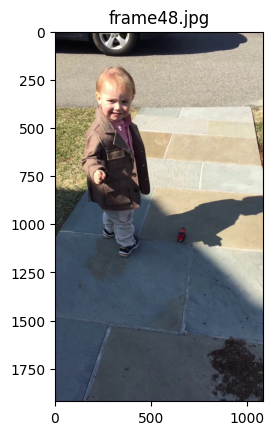

In [5]:
# display example frame
image = cv2.imread(os.path.join(folder_path, dir_list[48]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('on')
plt.title(dir_list[48])
plt.show()

### MediaPipe

In [3]:
# get bounding box of subject based mediapipe skeleton
    # adjust margins as needed
def calculate_bounding_box(landmarks, image_width, image_height, side_margin=150, top_margin=200, bottom_margin=50):
    x_coords = [landmark.x * image_width for landmark in landmarks.landmark]
    y_coords = [landmark.y * image_height for landmark in landmarks.landmark]
    bbox_xmin = max(min(x_coords) - side_margin, 0)
    bbox_ymin = max(min(y_coords) - top_margin, 0)
    bbox_xmax = min(max(x_coords) + side_margin, image_width)
    bbox_ymax = min(max(y_coords) + bottom_margin, image_height)
    return int(bbox_xmin), int(bbox_ymin), int(bbox_xmax), int(bbox_ymax)

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_mediapipe_box(bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax, ax):
    ax.scatter(bbox_xmin, bbox_ymin, color='green', marker='*', s=100, edgecolor='white', linewidth=1.25)
    ax.scatter(bbox_xmin, bbox_ymax, color='green', marker='*', s=100, edgecolor='white', linewidth=1.25)
    ax.scatter(bbox_xmax, bbox_ymin, color='green', marker='*', s=100, edgecolor='white', linewidth=1.25)
    ax.scatter(bbox_xmax, bbox_ymax, color='green', marker='*', s=100, edgecolor='white', linewidth=1.25)


I0000 00:00:1712967085.618300 1050540 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1712967085.645874 1067245 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.129.03), renderer: NVIDIA RTX A5500/PCIe/SSE2


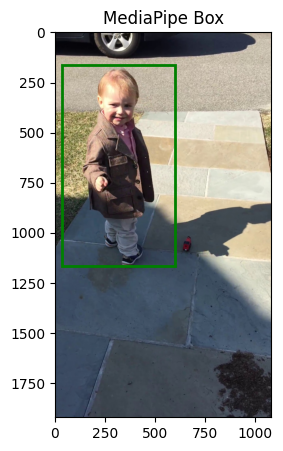

In [33]:
# initialize mediapipe model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# load image
image = cv2.imread(os.path.join(folder_path, dir_list[48]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
frame_height, frame_width, _ = image.shape

# get pose from mediapipe
results = pose.process(image)
if results.pose_landmarks:
    # get box based on mediapipe skeleton
    bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax = calculate_bounding_box(results.pose_landmarks, frame_width, frame_height)
    # segment anything probe
    input_box = np.array([bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax])

plt.figure(figsize=(5,5))
plt.imshow(image)
show_box(input_box, plt.gca())
#show_mediapipe_box(bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax, plt.gca())
plt.axis('on')
plt.title('MediaPipe Box')
plt.show()  

### Prompt Segment Anything with MediaPipe

In [36]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

I0000 00:00:1712967661.684043 1050540 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1712967661.711301 1073113 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.129.03), renderer: NVIDIA RTX A5500/PCIe/SSE2


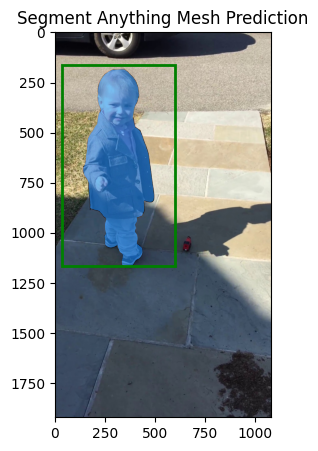

In [38]:
# initialize mediapipe model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# load image
image = cv2.imread(os.path.join(folder_path, dir_list[48]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
frame_height, frame_width, _ = image.shape

# get pose from mediapipe
results = pose.process(image)
if results.pose_landmarks:
    # get box based on mediapipe skeleton
    bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax = calculate_bounding_box(results.pose_landmarks, frame_width, frame_height)
    # segment anything probe
    input_box = np.array([bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax])

predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=False,
)

plt.figure(figsize=(5,5))
plt.imshow(image)
show_mask(masks, plt.gca())
show_box(input_box, plt.gca())
#show_mediapipe_box(bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax, plt.gca())
plt.axis('on')
plt.title('Segment Anything Mesh Prediction')
plt.show() 

### Create Segmented Frames
uncomment to save files

I0000 00:00:1712968577.481043 1050540 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1712968577.508121 1081634 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.129.03), renderer: NVIDIA RTX A5500/PCIe/SSE2
I0000 00:00:1712968577.510258 1050540 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1712968577.531912 1081635 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.129.03), renderer: NVIDIA RTX A5500/PCIe/SSE2


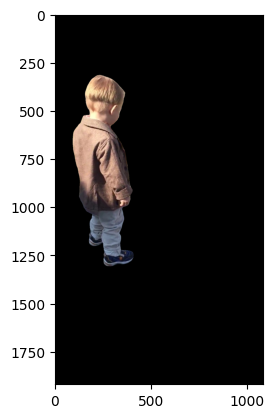

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


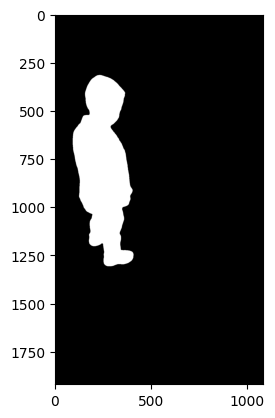

In [42]:
# initialize mediapipe model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# iterate through all frames
folder_path = "frames/"
dir_list = sort_dir(os.listdir(folder_path))

# create the options that will be used for mediapipe
base_options = python.BaseOptions(model_asset_path='deeplab_v3.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

# iterate through all frames
with python.vision.ImageSegmenter.create_from_options(options) as segmenter:
    for image_filename in dir_list:
        # load image
        image = cv2.imread(folder_path+image_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        frame_height, frame_width, _ = image.shape
        
        # get pose
        results = pose.process(image)
        if results.pose_landmarks:
            bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax = calculate_bounding_box(results.pose_landmarks, frame_width, frame_height)
            input_box = np.array([bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax])
        
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box,
            multimask_output=False,
        )

        condition = np.stack((masks[0],)*3, axis=-1)
        output_image = np.where(condition, image, 0)
        #plt.imshow(output_image)
        #plt.show()


        #print(f'Blackout sam background of blackout' + image_filename)
        #cv2.imwrite("blackout_sam_frames/blackout_sam_" + image_filename, cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))

        mask_image = np.where(condition, np.ones(image.shape)*255, 0)
        #plt.imshow(mask_image)
        #plt.show()

        #print(f'SAM mask frame of ' + image_filename)
        #cv2.imwrite("sam_mask_frames/sam_mask_"+image_filename,mask_image)

    plt.imshow(output_image)
    plt.show()

    plt.imshow(mask_image)
    plt.show()

### Create MHI from Segmented Frames

In [35]:
def update_mhi(mhi, frame, tau=25, kernel=(15,15)):
    # convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.GaussianBlur(frame, kernel, 0)
    
    # compute different between adjacent frames and threshold for binary image
    D_binary_image = cv2.absdiff(frame, mhi['prev_frame'])
    _, D_binary_image = cv2.threshold(D_binary_image, 25, 1, cv2.THRESH_BINARY)

    # update motion history image
    mhi['prev_frame'] = frame.copy()
    mhi['mhi'] = np.where(D_binary_image == 1, tau, np.maximum(mhi['mhi'] - 1, 0))
    
    
    mhi['mei'] = np.where(D_binary_image == 1, 1, mhi['mei'])

    # Normalize mhi
    normalized_mhi =  np.uint8(np.clip((mhi['mhi'] / tau), 0, 1)*255)
    return normalized_mhi

1920 1080


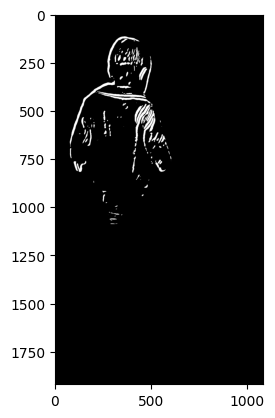

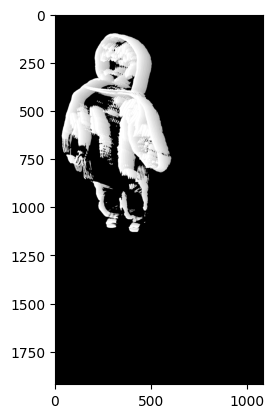

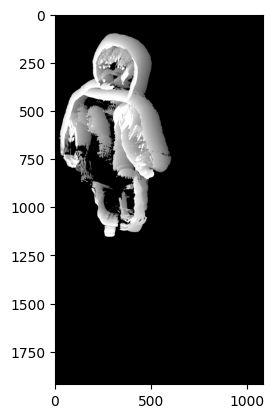

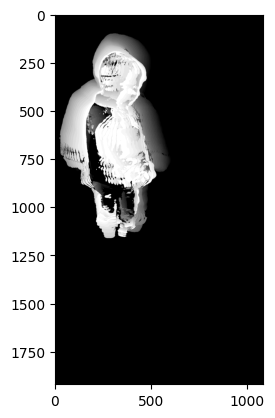

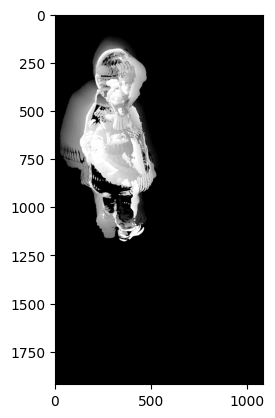

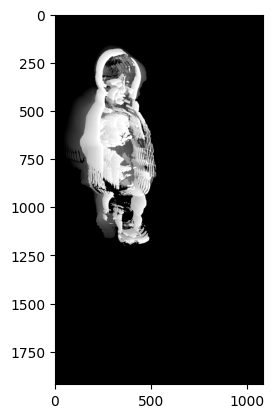

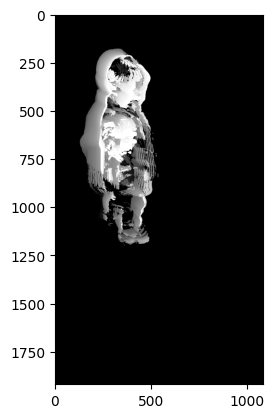

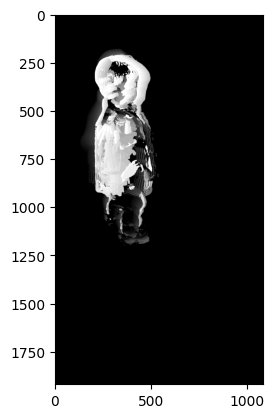

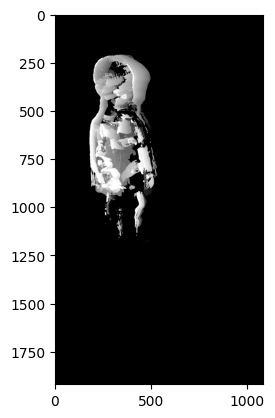

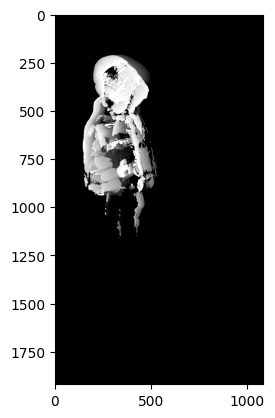

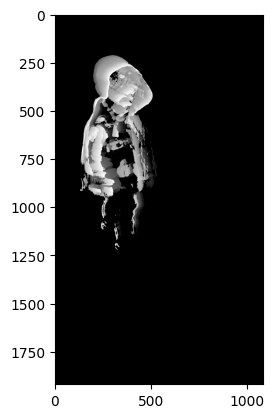

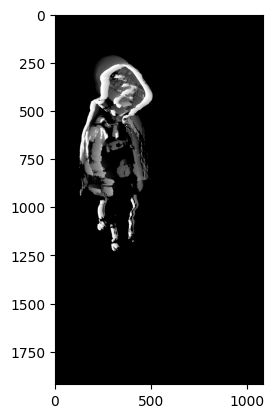

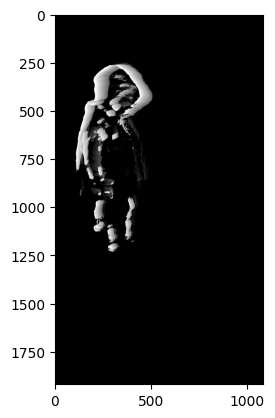

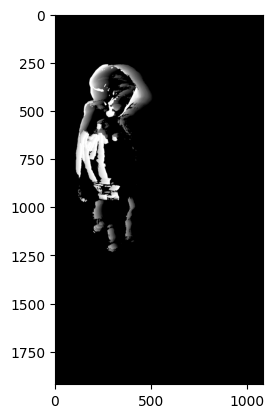

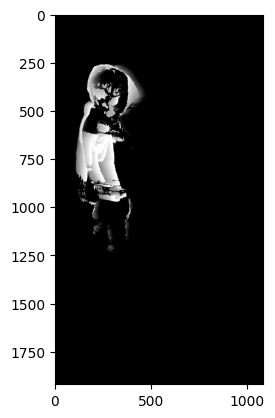

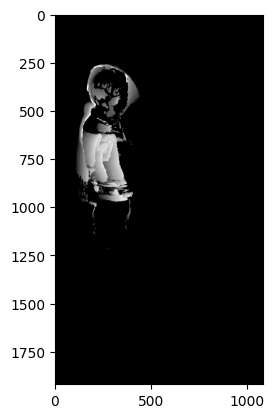

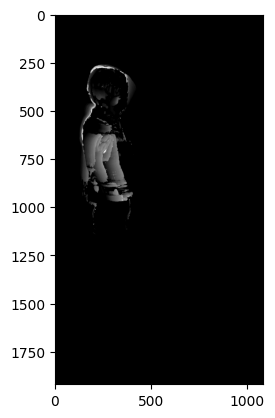

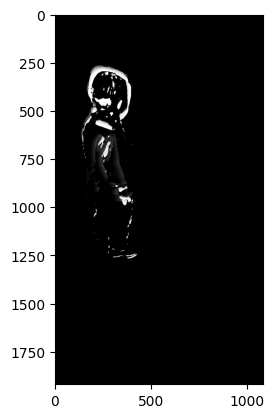

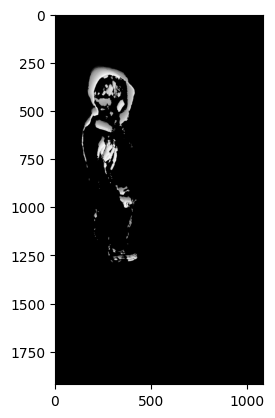

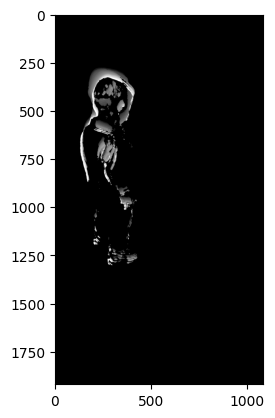

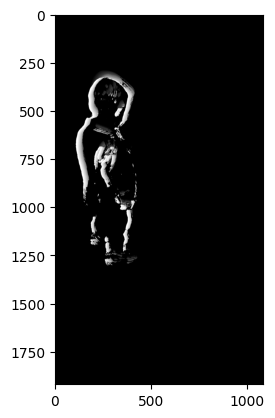

In [36]:
# iterate through all frames
folder_path = "blackout_sam_frames/"
dir_list = sort_dir(os.listdir(folder_path))

# start frame
frame = cv2.imread(os.path.join(folder_path, dir_list[9]))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# get frame height and width
h, w = frame.shape[:2]
print(h,w)

# parameters that need to be tuned
kernel = (15,15)
tau = 30

# initializae mhi and timestamp
mhi = {
    'prev_frame': cv2.GaussianBlur(frame, (15, 15), 0),
    'mhi': np.zeros((h, w), dtype=np.float32),
    'mei': np.zeros((h, w), dtype=np.float32)
}
timestamp = 0

# define codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('mhi2_output.avi', fourcc, 20.0, (w, h))

for file_name in dir_list[10:]:
    frame = cv2.imread(os.path.join(folder_path,file_name))

    timestamp += 1

    # update motion history
    mhi_image = update_mhi(mhi, frame, tau, kernel)
    
    if timestamp%10 == 1:
        plt.imshow(mhi_image, cmap='gray')
        plt.show()

    #out.write(mhi_image) #doesnt work
    out.write(cv2.cvtColor(mhi_image, cv2.COLOR_GRAY2BGR))

    # save mhi images in a folder
    cv2.imwrite("mhi_vid_2/mhi_" + file_name, cv2.cvtColor(mhi_image, cv2.COLOR_GRAY2BGR))

    # add updated mhi_image to video
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# release and destroy
out.release()
cv2.destroyAllWindows()